In [1]:
import sys
sys.path.append("..")  # Go to parent directory
from generating_data.generate_loaders import (
    create_Tang_multi_loaders,
    create_GM_test_multi_loaders
    )
from models.CNNs import flexCNN
from models.multi_class_trainer import multiTrainer

In [2]:
Tang_train_loader, Tang_val_loader, Tang_test_loader = create_Tang_multi_loaders('../data/pkl/moves/Tang_moves.pkl')
model =flexCNN(conv_layers=3, aff_layers=2, kernel_sizes=[3,3,3])
trainer = multiTrainer(net=model, train_loader=Tang_train_loader, val_loader=Tang_val_loader)

In [3]:
import torch.nn as nn
completed_model, best_model, train_losses, val_losses, train_acc, val_acc = trainer.train(
    optim_name='adamw',
    loss_function=nn.CrossEntropyLoss(),
    num_epochs=10,
    learning_rate=0.001,
    momentum=0.9,
    step_size=5,
    learning_rate_decay=0.9,
    acc_frequency=1,
    verbose=True
)

100%|██████████| 1186/1186 [00:38<00:00, 30.67it/s]


Epoch 1/10: Train Loss = 1.4652, Train Acc = 0.3733, Val Loss = 1.3165, Val Acc = 0.4394


100%|██████████| 1186/1186 [00:38<00:00, 30.92it/s]


Epoch 2/10: Train Loss = 1.2565, Train Acc = 0.4597, Val Loss = 1.2293, Val Acc = 0.4708


100%|██████████| 1186/1186 [00:37<00:00, 31.39it/s]


Epoch 3/10: Train Loss = 1.1947, Train Acc = 0.4856, Val Loss = 1.1976, Val Acc = 0.4815


100%|██████████| 1186/1186 [00:37<00:00, 31.40it/s]


Epoch 4/10: Train Loss = 1.1597, Train Acc = 0.5018, Val Loss = 1.1774, Val Acc = 0.4902


100%|██████████| 1186/1186 [00:37<00:00, 31.24it/s]


Epoch 5/10: Train Loss = 1.1326, Train Acc = 0.5146, Val Loss = 1.1540, Val Acc = 0.5048


100%|██████████| 1186/1186 [00:38<00:00, 30.61it/s]


Epoch 6/10: Train Loss = 1.1070, Train Acc = 0.5261, Val Loss = 1.1443, Val Acc = 0.5098


100%|██████████| 1186/1186 [00:38<00:00, 30.80it/s]


Epoch 7/10: Train Loss = 1.0881, Train Acc = 0.5360, Val Loss = 1.1362, Val Acc = 0.5149


100%|██████████| 1186/1186 [00:39<00:00, 30.31it/s]


Epoch 8/10: Train Loss = 1.0731, Train Acc = 0.5442, Val Loss = 1.1375, Val Acc = 0.5147


100%|██████████| 1186/1186 [00:38<00:00, 30.51it/s]


Epoch 9/10: Train Loss = 1.0581, Train Acc = 0.5506, Val Loss = 1.1358, Val Acc = 0.5154


100%|██████████| 1186/1186 [00:40<00:00, 29.23it/s]


Epoch 10/10: Train Loss = 1.0440, Train Acc = 0.5579, Val Loss = 1.1415, Val Acc = 0.5174


RuntimeError: Error(s) in loading state_dict for flexCNN:
	Unexpected key(s) in state_dict: "conv_layers.1.weight", "conv_layers.1.bias", "conv_layers.2.weight", "conv_layers.2.bias", "aff_layers.1.weight", "aff_layers.1.bias". 
	size mismatch for aff_layers.0.weight: copying a param with shape torch.Size([128, 512]) from checkpoint, the shape in current model is torch.Size([6, 1152]).
	size mismatch for aff_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([6]).

100%|██████████| 255/255 [00:06<00:00, 37.40it/s]


P: Accuracy: 48.49%
N: Accuracy: 46.25%
B: Accuracy: 49.39%
R: Accuracy: 32.59%
Q: Accuracy: 41.29%
K: Accuracy: 56.08%


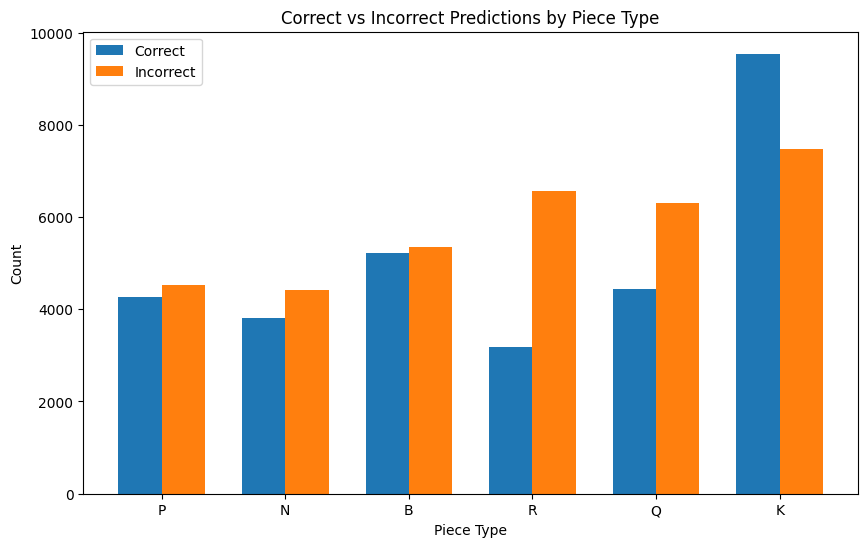


Overall Accuracy Metrics:
         Piece Type  Accuracy (%)  Recall (%)  F1 Score (%)
0                 P     48.485539   48.485539     48.026167
1                 N     46.248179   46.248179     43.857225
2                 B     49.388568   49.388568     46.319346
3                 R     32.587728   32.587728     37.721955
4                 Q     41.290984   41.290984     44.474542
5                 K     56.078063   56.078063     53.370629
Weighted   Weighted     46.765343   46.765343     46.489520


In [4]:
import torch
import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_per_piece_accuracy(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    class_correct = [0] * 6
    class_total = [0] * 6
    all_labels = []
    all_preds = []

    classes = ['P', 'N', 'B', 'R', 'Q', 'K']

    with torch.no_grad():
        for data in tqdm.tqdm(test_loader):
            X, y = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)

            # Collect all labels and predictions for metrics
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Calculate per-class accuracy
            for i in range(len(y)):
                label = y[i].item()
                class_total[label] += 1
                if predicted[i] == y[i]:
                    class_correct[label] += 1

    # Calculate metrics for each piece
    correct_counts = []
    incorrect_counts = []
    accuracies = []
    recalls = []
    f1_scores = []

    for i in range(6):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            recall = recall_score(all_labels, all_preds, labels=[i], average='macro')
            f1 = f1_score(all_labels, all_preds, labels=[i], average='macro')
            correct_counts.append(class_correct[i])
            incorrect_counts.append(class_total[i] - class_correct[i])
            accuracies.append(accuracy)
            recalls.append(recall * 100)
            f1_scores.append(f1 * 100)
            print(f"{classes[i]}: Accuracy: {accuracy:.2f}%")
        else:
            print(f"{classes[i]}: No samples available.")
            correct_counts.append(0)
            incorrect_counts.append(0)
            accuracies.append(0)
            recalls.append(0)
            f1_scores.append(0)

    # ✅ Plotting the results
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(classes))

    plt.bar(index, correct_counts, bar_width, label='Correct')
    plt.bar([i + bar_width for i in index], incorrect_counts, bar_width, label='Incorrect')

    plt.xlabel('Piece Type')
    plt.ylabel('Count')
    plt.title('Correct vs Incorrect Predictions by Piece Type')
    plt.xticks([i + bar_width / 2 for i in index], classes)
    plt.legend()
    plt.show()

    # ✅ Create a DataFrame for a summary
    df = pd.DataFrame({
        'Piece Type': classes,
        'Accuracy (%)': accuracies,
        'Recall (%)': recalls,
        'F1 Score (%)': f1_scores
    })

    # ✅ Calculate weighted metrics
    weighted_accuracy = accuracy_score(all_labels, all_preds) * 100
    weighted_recall = recall_score(all_labels, all_preds, average='weighted') * 100
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted') * 100

    # ✅ Add weighted metrics to the DataFrame
    df.loc['Weighted'] = ['Weighted', weighted_accuracy, weighted_recall, weighted_f1]

    print("\nOverall Accuracy Metrics:")
    print(df)

    return df

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df_metrics = evaluate_per_piece_accuracy(best_model, Tang_test_loader, device)

100%|██████████| 370/370 [00:09<00:00, 37.28it/s]


P: Accuracy: 53.57%
N: Accuracy: 52.96%
B: Accuracy: 50.84%
R: Accuracy: 27.93%
Q: Accuracy: 33.37%
K: Accuracy: 52.21%


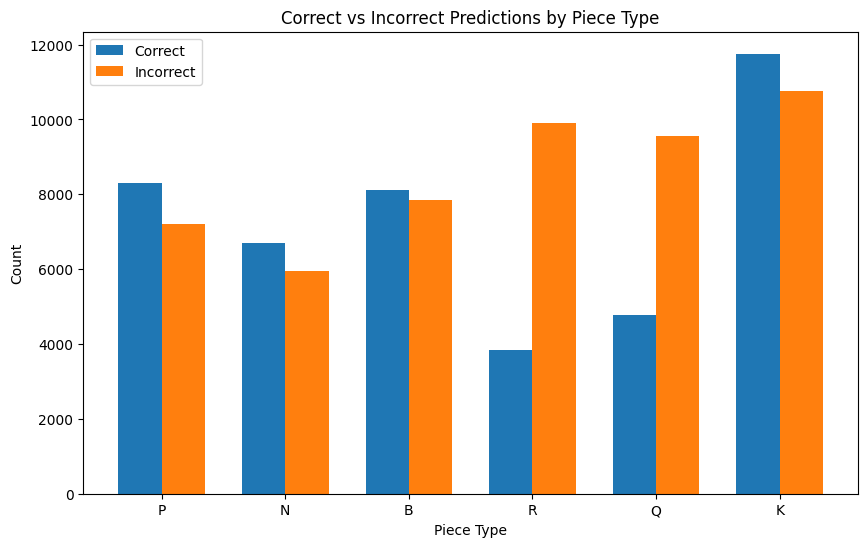


Overall Accuracy Metrics:
         Piece Type  Accuracy (%)  Recall (%)  F1 Score (%)
0                 P     53.573961   53.573961     52.600937
1                 N     52.964458   52.964458     48.354110
2                 B     50.842257   50.842257     47.283210
3                 R     27.930356   27.930356     34.725115
4                 Q     33.370520   33.370520     38.210051
5                 K     52.209246   52.209246     48.327031
Weighted   Weighted     45.931049   45.931049     45.351177


In [5]:
Ediz_test_loader = create_GM_test_multi_loaders('../data/pkl/moves/ediz_gurel_moves.pkl')
df_metrics = evaluate_per_piece_accuracy(best_model, Ediz_test_loader, device)

100%|██████████| 312/312 [00:08<00:00, 37.17it/s]


P: Accuracy: 48.95%
N: Accuracy: 49.61%
B: Accuracy: 49.17%
R: Accuracy: 31.79%
Q: Accuracy: 38.74%
K: Accuracy: 49.55%


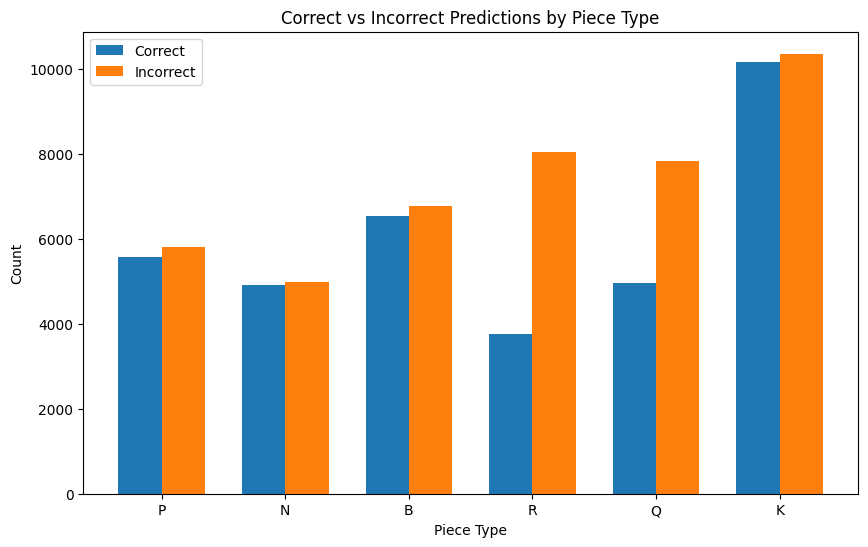


Overall Accuracy Metrics:
         Piece Type  Accuracy (%)  Recall (%)  F1 Score (%)
0                 P     48.954122   48.954122     48.258534
1                 N     49.610757   49.610757     44.375113
2                 B     49.169110   49.169110     46.187533
3                 R     31.785048   31.785048     36.113251
4                 Q     38.742473   38.742473     41.684547
5                 K     49.549242   49.549242     49.244479
Weighted   Weighted     45.043552   45.043552     44.831165


In [6]:
meneer_test_loader = create_GM_test_multi_loaders('../data/pkl/moves/meneermandje_moves.pkl')
df_metrics = evaluate_per_piece_accuracy(best_model, meneer_test_loader, device)